![img](Images/vaccine.jpg)

## Immunization Predictor
**By:** Clara Giurgiu

## Overview

**TechHealth Access** is an organization that combines technology and service as it strives to educate healthcare providers and public health officials on how to use modern technology to better help their patients and communities.\
The project aims to develop an algorithm that can predict people or groups of people that will most likely not get a novel vaccine such as the H1N1 vaccine in 2009.\
The algorithim can be used by health care providers and public health agencies to predict those that might not get vaccinations and face risk of potential complications from preventable diseases. 

## Business Understanding
Our company believes vaccine development and acceptance are key to stop the spread of existing and novel infectious diseases and pandemics as we recently experienced with COVID-19.\
With a prediction model that classifies whether or not someone gets a vaccine, we can address areas such as vaccine hesitancy and misinformation and how public health agencies can address them to impact immunization rates. 

## Data Understanding
The National 2009 H1N1 Flu Survey (NHFS) sponsored by the National Center for Immunization and Respiratory Diseases (NCIRD) and conducted jointly with the National Center for Health Statistics (NCHS) and the Centers for Disease Control and Prevention (CDC).    
The data was colleted over the phone to monitor influenza immunizations during the 2009-10 flu season and in response to the 2009 H1N1 pandemic and it has over 26 thousand responses. It asked whether the respondants had received the H1N1 and seasonal flu vaccines as well as their social, economic and demographic backgrounds. 

## Data Preparation

In [745]:
# basic imports for EDA
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns

# imports for modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyClassifier


In [746]:
# importing training features
vaccines_features = pd.read_csv('Data/training_set_features.csv')
# importing training labels
vaccines_labels = pd.read_csv('Data/training_set_labels.csv')

In [747]:
vaccines_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [748]:
vaccines_labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [749]:
vaccines_features.shape, vaccines_labels.shape

((26707, 36), (26707, 3))

The data is separated in two datasets with 26,707 responses. One contains 35 columns with the survey answers of the respondents' backfround information and one column with an assigned ID. The second dataset contains the vaccination status of the respondants with the corresponding ID. I will merge datasets for EDA and prepare for modeling based on the matching ID.

In [750]:
# merging features and labels for EDA 
vax_df = pd.merge(vaccines_features, vaccines_labels, on='respondent_id')
vax_df.shape

(26707, 38)

With the merged datasets we have 37 response columns to explore further and see which features can be used for analysis and modeling.

In [751]:
vax_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [752]:
vax_df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


As this is survey data and mostly ordinal or binary, there are not any potential issues with outliers. 

In [753]:
vax_df.describe(include='object')

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [754]:
# loop for looking at values
for column in vax_df:
    print(vax_df[column].unique())

[    0     1     2 ... 26704 26705 26706]
[ 1.  3.  2.  0. nan]
[ 0.  2.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 1.  0. nan]
[ 1.  0. nan]
[ 0. nan  1.]
[ 0. nan  1.]
[ 0.  1. nan]
[ 0.  1. nan]
[ 0.  1. nan]
[ 1. nan  0.]
[ 3.  5.  4.  2.  1. nan]
[ 1.  4.  3.  2.  5. nan]
[ 2.  4.  1.  5.  3. nan]
[ 2.  4.  5.  3.  1. nan]
[ 1.  2.  4.  3.  5. nan]
[ 2.  4.  1.  5. nan  3.]
['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
['White' 'Black' 'Other or Multiple' 'Hispanic']
['Female' 'Male']
['Below Poverty' '<= $75,000, Above Poverty' '> $75,000' nan]
['Not Married' 'Married' nan]
['Own' 'Rent' nan]
['Not in Labor Force' 'Employed' 'Unemployed' nan]
['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']
['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']
[ 0.  2.  1.  3. nan]
[ 0.  3.  2.

According to the data source and .info(), most columns are either binary or ordinal. A few categorical and random character string.\
For more info see here: [https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/]

In [755]:
# exploring target
vax_df['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [756]:
# exploring target
vax_df['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

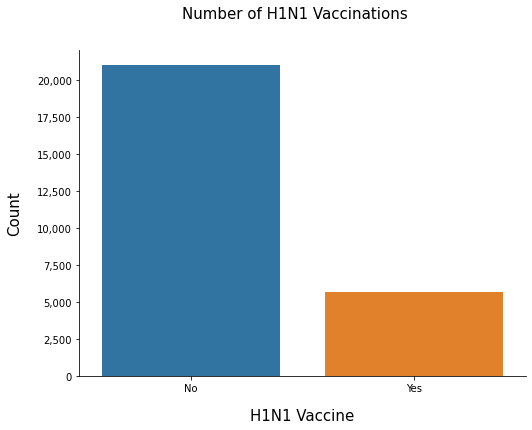

In [944]:
# Visualizing H1N1 vaccine count

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=vax_df, x='h1n1_vaccine')
plt.suptitle('Number of H1N1 Vaccinations', fontsize=15)
plt.xlabel('H1N1 Vaccine', labelpad=15, fontsize=15)
plt.ylabel('Count', labelpad=15, fontsize=15)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
sns.despine()

# plt.savefig('Images/h1n1_vax.png', dpi=300);

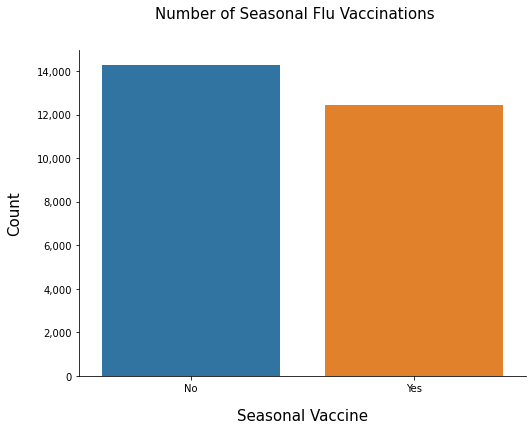

In [957]:
# Visualizing Seasonal flu vaccine count

fig, ax = plt.subplots( figsize=(8,6))
sns.countplot(data=vax_df, x='seasonal_vaccine')
plt.suptitle('Number of Seasonal Flu Vaccinations', fontsize=15)
plt.xlabel('Seasonal Vaccine', labelpad=15, fontsize=15)
plt.ylabel('Count', labelpad=15, fontsize=15)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
sns.despine()
#plt.savefig('Images/seasonal_vax.png', dpi=300);

For this model, I will be classifying H1N1 vaccinations. Because there is a vast class imbalance (only 21% received vaccine), I will have to balance the class weight hyperparameter in the model to ensure enough representation of the minority class in the model. \
I could also potentially infer as to what factors determine novel vaccinations such as H1N1 compared to the seasonal flu vaccine. 

Some of the features I want to focus on are age group, sex, race, education, H1N1 knowledge, H1N1 concern, and doctor reccomendation of the vaccine as we want to know how to better reach the population and educate about disease prevention through immunization. Below are comparisons on h1n1 and seasonal flu vaccination counts:

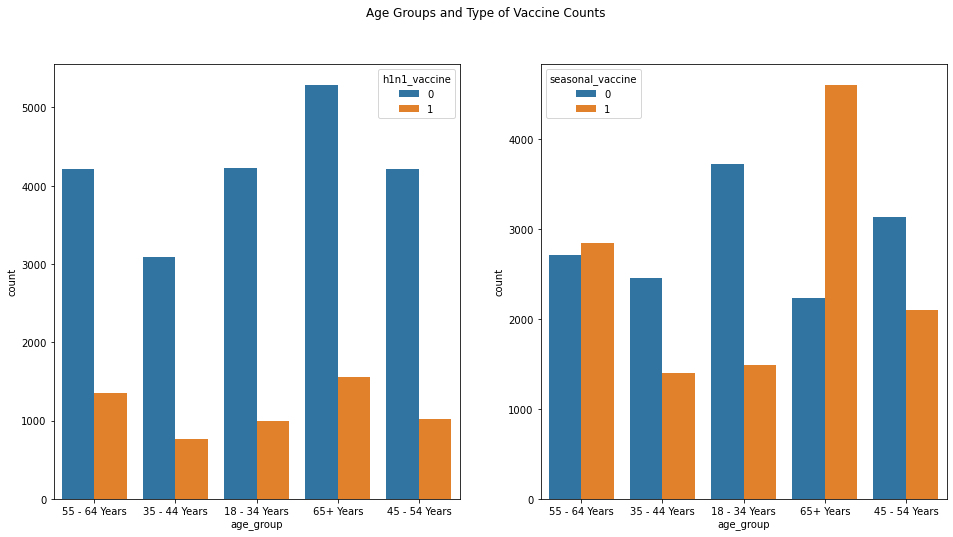

In [759]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
sns.countplot(data=vax_df, x='age_group', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='age_group', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('Age Groups and Type of Vaccine Counts')
plt.show()

Overall, the seasonal flu vaccination rate is higher in all groups. We can see particularly that the 55-64 years and 65+ Years age groups habr a high seasonal flu vaccination rate but did not receive the H1N1 as much. 

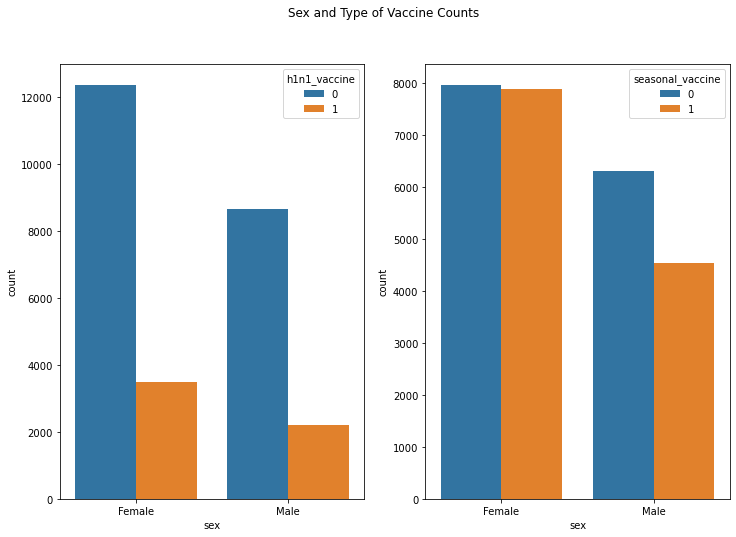

In [760]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
sns.countplot(data=vax_df, x='sex', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='sex', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('Sex and Type of Vaccine Counts')
plt.show()

There is a similar trend with sex, females have a higher rate of both vaccines but substantially higher seasonal vaccine. 

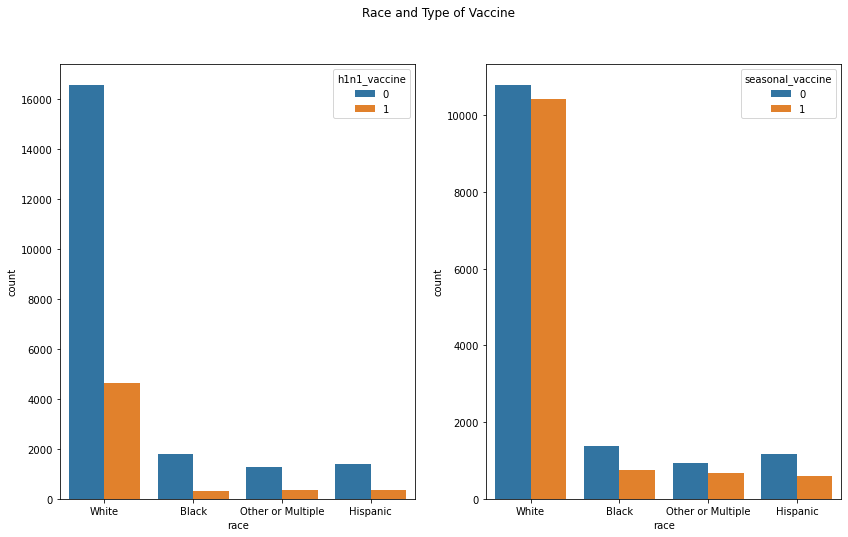

In [761]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.countplot(data=vax_df, x='race', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='race', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('Race and Type of Vaccine')
plt.show()

The above graphs show that race may have some relation to vaccination rates, but further analysis will be required to make assumptions or recomendations on this topic.

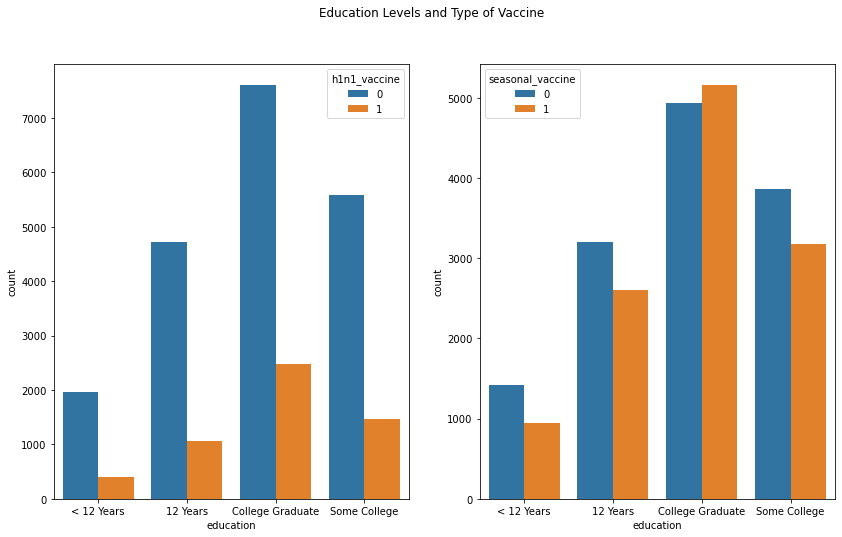

In [762]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.countplot(data=vax_df, x='education', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='education', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('Education Levels and Type of Vaccine')

plt.show()

Similarly, education level can be a factor. With feature importance later on we can see if it is significant enough.

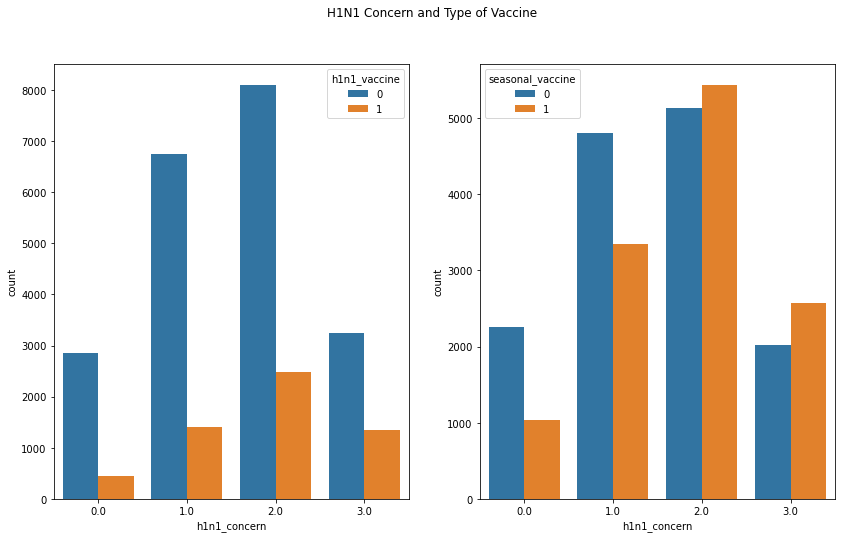

In [763]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.countplot(data=vax_df, x='h1n1_concern', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='h1n1_concern', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('H1N1 Concern and Type of Vaccine')
plt.show()

It is not right away clear if increasing concern of H1N1 infection is related to vaccination as it peaks at a 2 or 'somewhat concern' but decreases when the concern level is 'very high.'

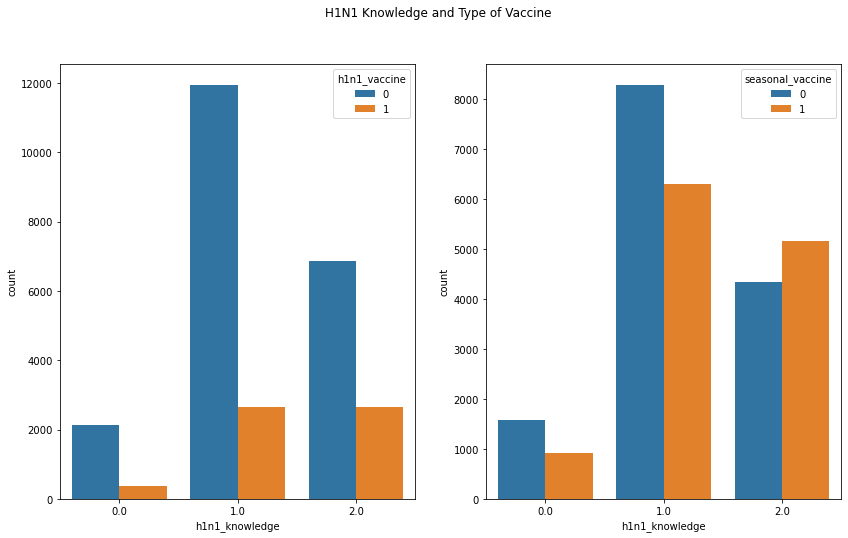

In [764]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.countplot(data=vax_df, x='h1n1_knowledge', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='h1n1_knowledge', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('H1N1 Knowledge and Type of Vaccine')

plt.show()

As knowledge of H1N1 increases so does the vaccination rate but it seems tied at 1 and 2.

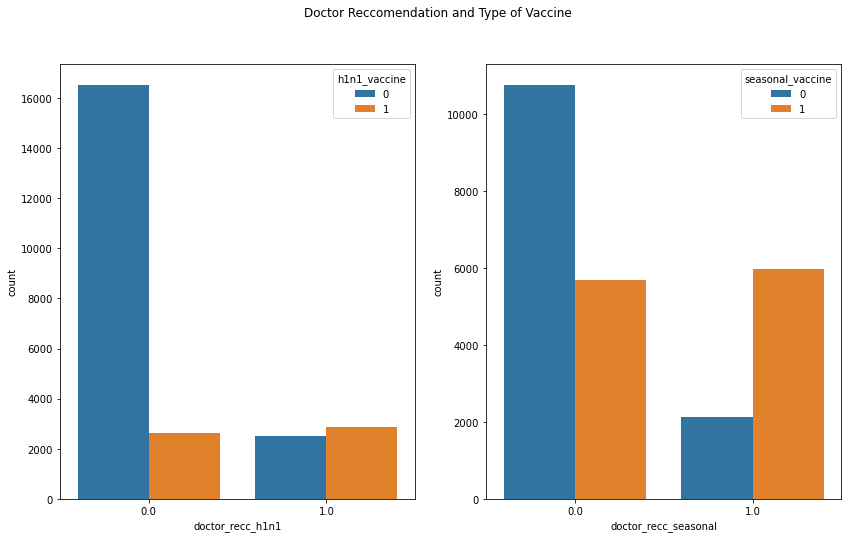

In [765]:
# visualizing doctor recommendation features
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.countplot(data=vax_df, x='doctor_recc_h1n1', hue='h1n1_vaccine', ax=ax1)
sns.countplot(data=vax_df, x='doctor_recc_seasonal', hue='seasonal_vaccine', ax=ax2)
plt.suptitle('Doctor Reccomendation and Type of Vaccine')

plt.show()

There is a very small increase when the physician recommends the vaccine. 

After looking at descriptive statistics and some distributions, I will create a new data frame for analysis by removing irelevant columns or the random characters as it will not be useful for interpretation.

In [766]:
# new data frame for vaccine classification
# removing columns not relevant for analysis
h1n1_df = vax_df.drop(columns=['respondent_id', 'household_children', 'health_insurance',
                      'household_adults', 'employment_industry', 'employment_status',
                      'employment_occupation', 'hhs_geo_region', 'census_msa', 'child_under_6_months', 'health_worker',
                              'marital_status', 'rent_or_own', 'seasonal_vaccine'])
h1n1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  opinion_h1n1_vacc_effective  26316 non-null  float64
 13  opinion_h1n1_ris

In [954]:
display(h1n1_df.isna().sum())
print('total nulls:', h1n1_df.isna().sum().sum())

h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
doctor_recc_seasonal           2160
chronic_med_condition           971
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
h1n1_vaccine                      0
dtype: int64

total nulls: 14653


The new dataframe has now 23 features and the target. After splitting the data for model training and testing, I will use a column transformer to fill in null values and transform the categorical columns.

I chose *recall* as my primary evaluation metric for my models because this is a measure of how many cases we predict will not get the vaccine, and they truly don't get it. 
With false negatives, we can't confidently determine what factors might lead groups not to get vaccinated and the goal is to direct our efforts to improve on those

### Preparing for Modeling

In [767]:
# separing features and target
X = h1n1_df.drop(columns=['h1n1_vaccine'])
y = h1n1_df['h1n1_vaccine'] 

# train test split with default tests size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# checking split volume
X_train.shape, X_test.shape

((20030, 23), (6677, 23))

In [768]:
# sanity check of target
y_train.shape, y_test.shape

((20030,), (6677,))

After splitting for testing and training data, the training set consists of 20,030 points with 23 columns, the testing set has 6,677 rows and 23 columns. The fewer testing points will be enought, as I will be doing cross validation with the models.

### Dummy Model

In [852]:
# dummy model with 'most_frequent'
# class imbalance 
dummy_model =  DummyClassifier(strategy="most_frequent")

# fitting to training data
dummy_model.fit(X_train, y_train)

# training score
dummy_model.score(X_train, y_train)

0.7900149775336994

In [853]:
cross_val_score(dummy_model, X_train, y_train)

array([0.7900649 , 0.7900649 , 0.7900649 , 0.7900649 , 0.78981528])

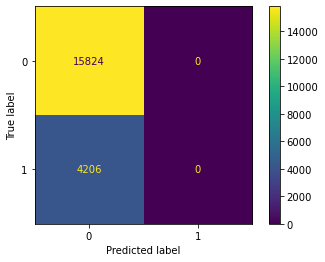

In [854]:
# training confusion matrix
plot_confusion_matrix(dummy_model, X_train, y_train);

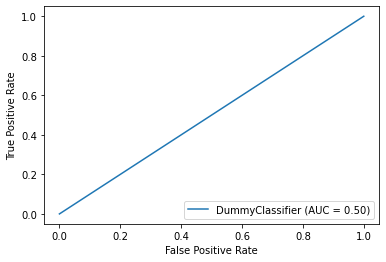

In [849]:
plot_roc_curve(dummy_model, X_train, y_train)

**Testing**

In [861]:
# testing score
dummy_acc = dummy_model.score(X_test, y_test)
dummy_acc

0.7801407817882282

In [860]:
dummy_pred = dummy_model.predict(X_test)
dummy_rec = recall_score(y_test, dummy_pred)
dummy_rec

0.0

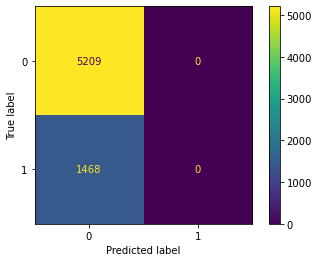

In [776]:
# testing confusion matrix
plot_confusion_matrix(dummy_model, X_test, y_test);

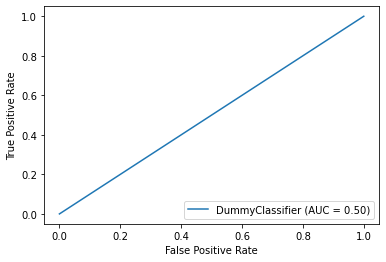

In [777]:
plot_roc_curve(dummy_model, X_test, y_test)

As expected, the dummy model is predicting the most frequent class which is 0.

### Pipeline
I will create a pipeline to process nulls and categorical columns.

In [778]:
# separating numerical columns to impute nulls with pipeline
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc']

In [779]:
# separating categorigal columns to one hot encode and impute nulls
cat_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty']

In [780]:
# numerical pipeline with simple imputer
num_pipe = Pipeline(steps=[('num_impute', SimpleImputer(strategy='most_frequent'))])

#categorical pipeline with simple imputer and onehotencoder
cat_pipe = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


In [781]:
# creating column transformer with above pipelines
CT = ColumnTransformer(transformers=[('num_pipe', num_pipe, num_cols),
                                         ('cat_pipe', cat_pipe, cat_cols)],
                           remainder='passthrough')

### Decision Tree 
Now that I created the pipeline, I will create a baseline Decision Tree

In [782]:
# instantialing classifier
# using hyperparameter class_weight due to class imbalance in target
# everything else default
dt_model = Pipeline(steps=[('ct', CT),
                            ('dt', DecisionTreeClassifier(class_weight='balanced'))])

# fitting to training data
dt_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',...
                                                   'opinio

In [783]:
# training score
dt_model.score(X_train, y_train)

0.9985022466300549

The training score is high due to overfitting since this model did not have any parameter tuning other than class balance.

In [946]:
# cross-validating with cv=5
cross_val_score(dt_model, X_train, y_train).mean()


0.754618072890664

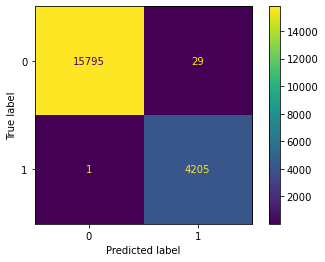

In [785]:
# training confusion matrix
plot_confusion_matrix(dt_model, X_train, y_train);

The base decision tree seems to be very overfit and with low cross-val score.

In [786]:
# test score
dt_acc = dt_model.score(X_test, y_test)
dt_acc

0.7605211921521642

Worse than dummy model.

In [787]:
dt_pred = dt_model.predict(X_test)

In [788]:
# recall score
dt_recall = recall_score(y_test, dt_pred)
dt_recall

0.4366485013623978

As recall is my primary metric, this will be the baseline and will use a gridsearch to iterate through random forest models and compare the recall scores.

### Random Forest

In [791]:
# random forest with column transformer
rfc_model = Pipeline(steps=[('ct', CT),
                            ('rfc', RandomForestClassifier(class_weight='balanced'))])

# list of parameters for grid search
rfc_params = {}
rfc_params['rfc__criterion'] = ['gini', 'entropy']
rfc_params['rfc__min_samples_leaf'] = [1, 5, 10]
rfc_params['rfc__max_depth'] = [1, 5, 10]

In [792]:
# instanciating grid search 
rfc_search = GridSearchCV(estimator=rfc_model,
                     param_grid=rfc_params,
                     cv=10, verbose=3, n_jobs=-3)

rfc_search.fit(X_train, np.ravel(y_train))

# saving the best estimation from grid search as my final model
best_rfc_model = rfc_search.best_estimator_

best_rfc_model

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-3)]: Done 108 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-3)]: Done 180 out of 180 | elapsed:   25.3s finished


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',...
                                                   'opinio

In [793]:
rfc_search.best_score_

0.8023964053919121

In [947]:
# renamig as final for training and testing
rfc_final = best_rfc_model

# fitting to training data
rfc_final.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',...
                                                   'opinio

In [948]:
# training score 
rfc_final.score(X_train, y_train)

0.845781328007988

In [949]:
cross_val_score(rfc_final, X_train, y_train).mean()

0.8028956565152272

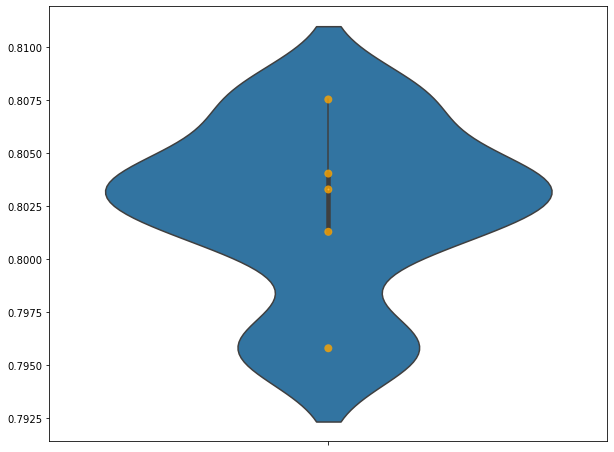

In [950]:
# saving all cv scores to visualize
cv_scores = cross_val_score(rfc_final, X_train, y_train)

fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(y=cv_scores, ax=ax, bw=.4)
sns.swarmplot(y=cv_scores, color='orange', size=8, alpha= 0.8, ax=ax);

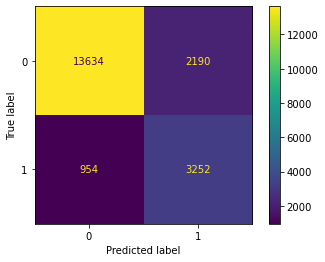

In [800]:
# training confusion matrix
plot_confusion_matrix(rfc_final, X_train, y_train);

In [961]:
# test score
rfc_acc = rfc_final.score(X_test, y_test)
rfc_acc

0.8020068893215516

In [802]:
rfc_pred = rfc_final.predict(X_test)

In [960]:
rfc_recall = recall_score(y_test, rfc_pred)
rfc_recall

0.6505449591280654

After 180 fits through a grid search, I arrived at a model that has an accuracy of 80% and recall of 65%,  increase almost 22% from basic decision tree.

### Models Comparison

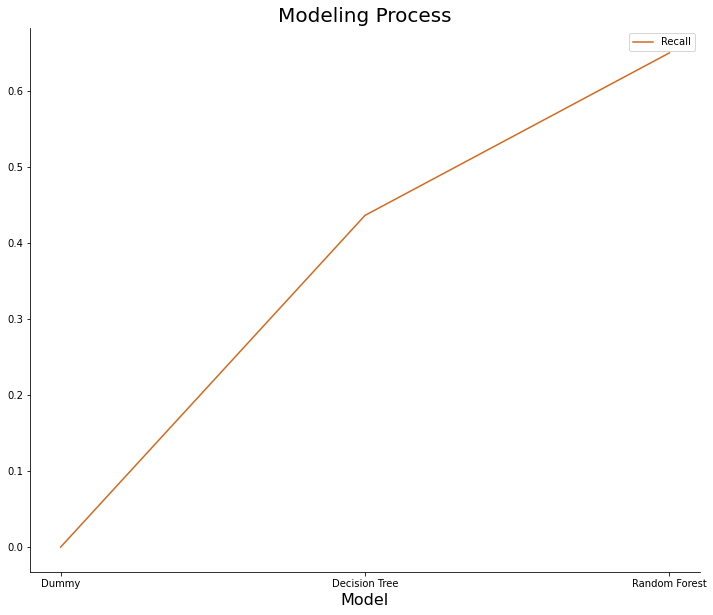

In [956]:
# joinning recall scores for dummy, baseline decision tree and random forest
model_scores = [dummy_rec, dt_recall, rfc_recall]

# making into dataframe for plotting
rec_scores_all = pd.DataFrame(model_scores, columns=['Recall'])

# line plot of recall progression
rec_scores_all.plot.line(figsize=(12,10), color='#D2691E')
plt.xticks(ticks=[0,1,2], labels=['Dummy','Decision Tree', 'Random Forest'], rotation=360)
plt.xlabel('Model',  fontsize=16)
sns.despine()
plt.title('Modeling Process', fontsize=20);
#plt.savefig('Images/model_rec__line_comparison.png', dpi=300);

**Comparing Accuracy and Recall of untuned Decision Tree and optimized Random Forest.**

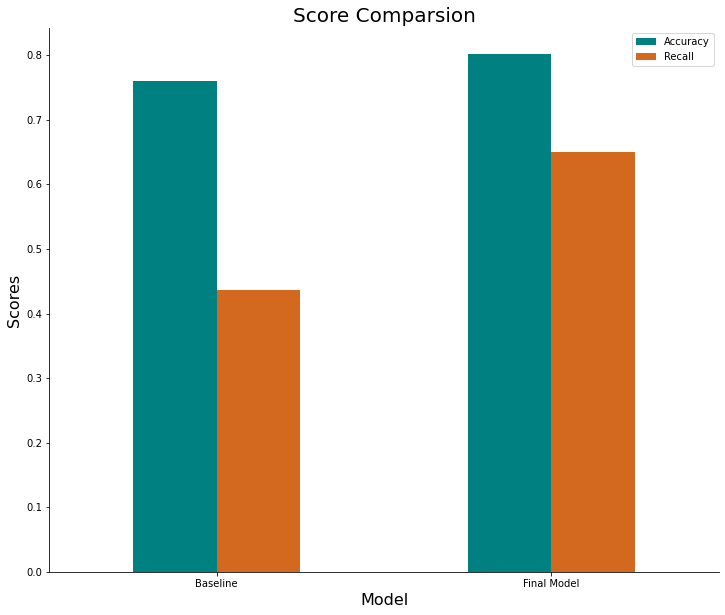

In [958]:
# joinning accuracy and recall scores for baseline decision tree and random forest
acc = [dt_acc, rfc_acc]
rec = [dt_recall, rfc_recall]
# making into dataframe for plotting, then joining
rec_scores = pd.DataFrame(rec, columns=['Recall'])
acc_scores = pd.DataFrame(acc, columns=['Accuracy'])
scores = acc_scores.join(rec_scores)

# visualizing both accuracy and recall
scores.plot.bar(figsize=(12,10), color=('#008080', '#D2691E'))
plt.xticks(ticks=[0,1], labels=['Baseline', 'Final Model'], rotation=360)
plt.ylabel('Scores',  fontsize=16)
plt.xlabel('Model',  fontsize=16)
sns.despine()
plt.title('Score Comparsion', fontsize=20)
#plt.savefig('Images/model_acc_rec_comparison.png', dpi=300);

## Insights

Now that I have a final model, I will use the feature_importances to see that are the top determinants for getting immunizations.

In [936]:
# feature importances for inference
importances = list(rfc_final['rfc'].feature_importances_)
importances

[0.025643657095747275,
 0.024610699200187467,
 0.006602120452394695,
 0.007823422246602532,
 0.007547596349013463,
 0.007369036907679965,
 0.009525548751885052,
 0.00904890625915858,
 0.009053457209823364,
 0.24020341680730745,
 0.05112012345906654,
 0.01129799302549682,
 0.1485011390348544,
 0.14696909365699676,
 0.02367129952511683,
 0.04015210170186851,
 0.07877367415863284,
 0.020484862912566126,
 0.008066626873964384,
 0.006939100763851711,
 0.006495500013411325,
 0.007760120539032283,
 0.008629788975630118,
 0.007397392982119013,
 0.006585610429419849,
 0.00904975923222804,
 0.006740952912847811,
 0.007494322995206581,
 0.005163126382553979,
 0.005087876767567247,
 0.008378926662713546,
 0.007768503257221338,
 0.007674641731364741,
 0.007060058730989338,
 0.008815155939483895,
 0.006494386055996136]

In [935]:
encoded_features = list(rfc_final['ct'].named_transformers_['cat_pipe']['ohe'].get_feature_names())
encoded_features

['x0_18 - 34 Years',
 'x0_35 - 44 Years',
 'x0_45 - 54 Years',
 'x0_55 - 64 Years',
 'x0_65+ Years',
 'x1_12 Years',
 'x1_< 12 Years',
 'x1_College Graduate',
 'x1_Some College',
 'x2_Black',
 'x2_Hispanic',
 'x2_Other or Multiple',
 'x2_White',
 'x3_Female',
 'x3_Male',
 'x4_<= $75,000, Above Poverty',
 'x4_> $75,000',
 'x4_Below Poverty']

In [937]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [938]:
feature_names = num_cols + encoded_features

In [939]:
# zipping features and importance for graph
feat_imp = []
for name, importance in zip(feature_names, importances):
    feat_imp.append((name, importance))
# sorting and getting top 10    
feat_imp.sort(key= lambda x: x[1], reverse=True)
feat_imp[:10]

[('doctor_recc_h1n1', 0.24020341680730745),
 ('opinion_h1n1_vacc_effective', 0.1485011390348544),
 ('opinion_h1n1_risk', 0.14696909365699676),
 ('opinion_seas_risk', 0.07877367415863284),
 ('doctor_recc_seasonal', 0.05112012345906654),
 ('opinion_seas_vacc_effective', 0.04015210170186851),
 ('h1n1_concern', 0.025643657095747275),
 ('h1n1_knowledge', 0.024610699200187467),
 ('opinion_h1n1_sick_from_vacc', 0.02367129952511683),
 ('opinion_seas_sick_from_vacc', 0.020484862912566126)]

In [940]:
# creating data freame
importance_df = pd.DataFrame(feat_imp[:10], columns=['Feature', 'Importance'])
# changing feature name style
importance_df['Feature'] = importance_df['Feature'].replace(['doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective',
                            'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'h1n1_concern',
                            'h1n1_knowledge', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc'],
                            ['Dr. Recommended H1N1 Vax', 'Opinion-Getting Sick w/ H1N1 flu',
                             'Opinion-H1N1 Vax Effectiveness', 'Opinion-Sick w/ Seasonal flu',
                            'Dr. Recommended Seasonal Vax','Opinion-Seasonal Vax Effectiveness', 'Concern-H1N1 flu',
                            'Knowledge-H1N1 flu', 'Opinion-Sick From H1N1 Vax',
                             'Opinion-Sick From Seasonal Vax'])
importance_df

,Feature,Importance
0,Dr. Recommended H1N1 Vax,0.240203
1,Opinion-H1N1 Vax Effectiveness,0.148501
2,Opinion-Getting Sick w/ H1N1 flu,0.146969
3,Opinion-Sick w/ Seasonal flu,0.078774
4,Dr. Recommended Seasonal Vax,0.051120
5,Opinion-Seasonal Vax Effectiveness,0.040152
6,Concern-H1N1 flu,0.025644
7,Knowledge-H1N1 flu,0.024611
8,Opinion-Sick From H1N1 Vax,0.023671
9,Opinion-Sick From Seasonal Vax,0.020485


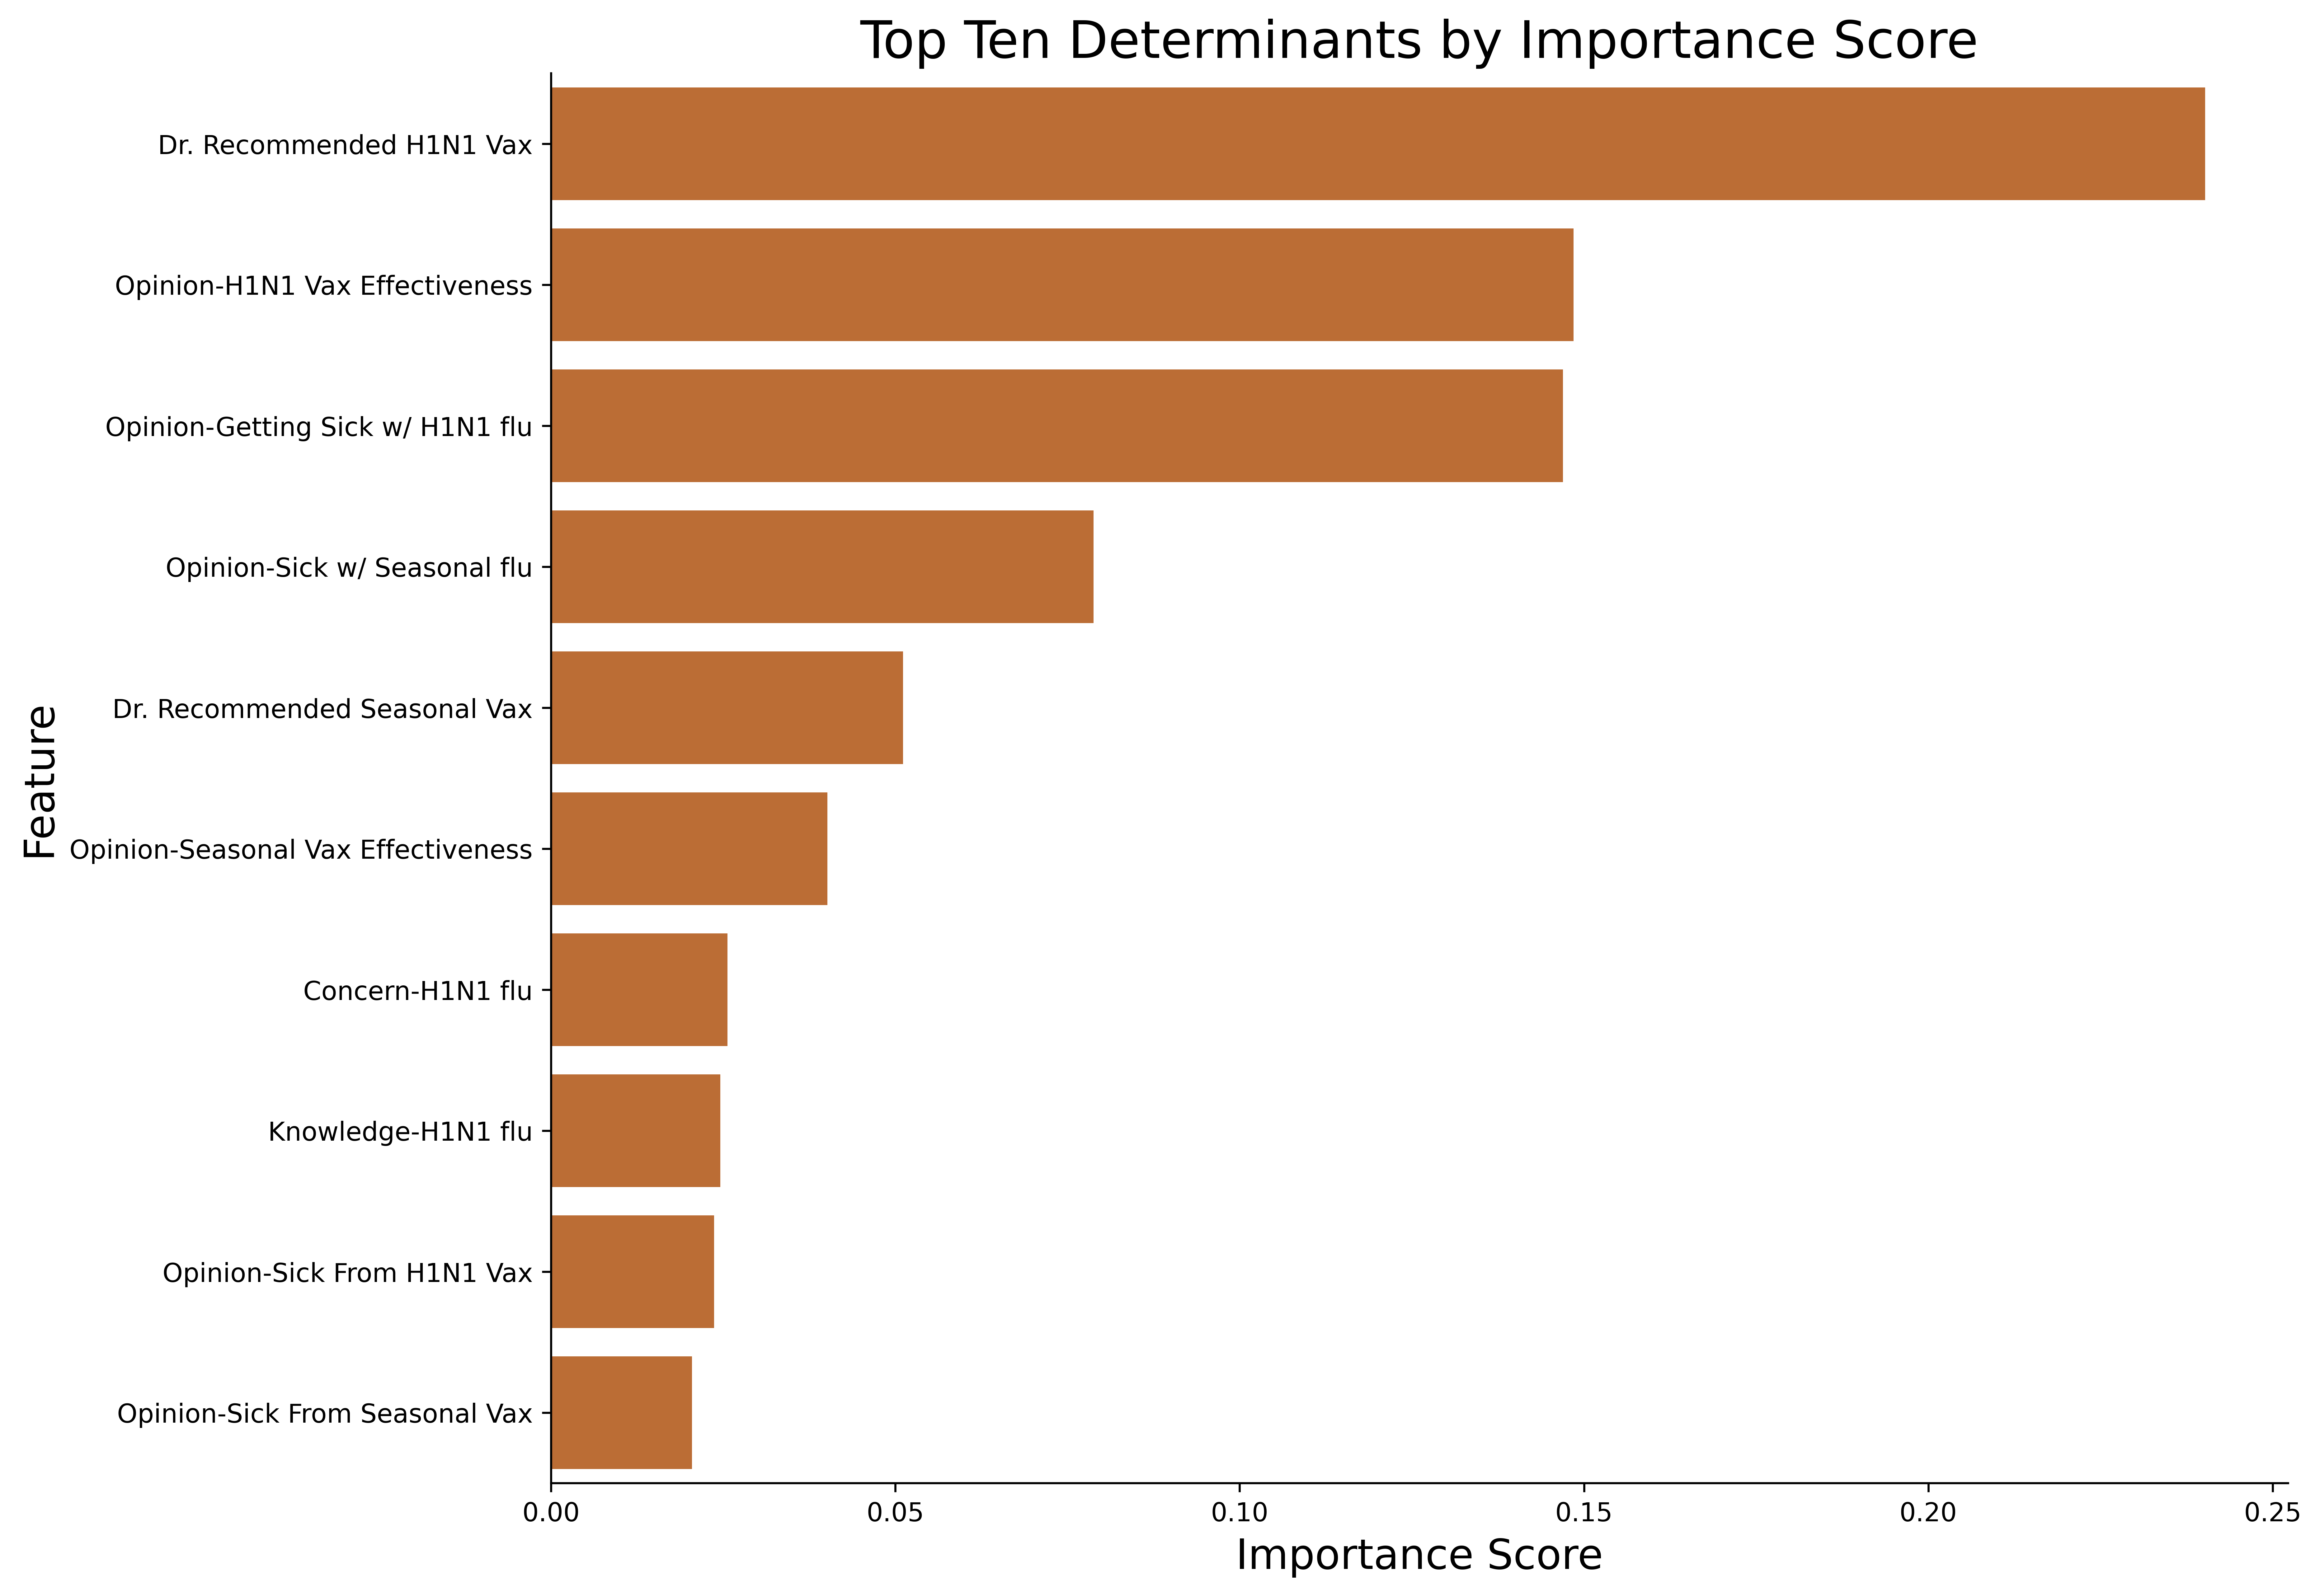

In [959]:
fig, ax = plt.subplots(figsize=(12,10), dpi=600)
sns.barplot(data=importance_df, y='Feature', x='Importance', color='#D2691E')
plt.title("Top Ten Determinants by Importance Score", fontsize=20)
plt.xlabel('Importance Score', fontsize=16)
plt.ylabel('Feature', fontsize=16)
sns.despine()
#plt.savefig('Images/Important_features.png', dpi=300);

The most importance features that I extracted from this model can potentially be used to increase the vaccination rates.
For example the top 1 determinant for getting the H1N1 vaccine was recommendation from a physician to get the vaccine. In this case we would to encourage primary care locations to conduct routine continuing education programs for staff so that they can provide patient with the accurate education about the benefits and risks of immunizations and information about the diseases we want to prevent.

## Conclusion

Comparing the accuracy and recall scores from all three models, the third model had the highest accuracy of 80% with a recall score of 65%. I recommend that health care providers and public health agencies use this model as its application can help in predicting who will be at risk of not receiving immunizations.

Additionally it shows that some top determinants for that choice are recommendation from a physician to get the vaccine, general thoughts about the vaccine effectivenes and the risk of getting sick with the H1N1 flu. With that in mind, providers can identify the best way to improve on those areas and education their patients.  

### Next Steps

I would like to look into more recent data, this problem of a new vaccine is very similar to what we experienced when COVID-19 mRNA vaccines became available. According to OurWorldinData.org, in the United States, specifically, while the rate of at least one dose of the vaccine increased, the number of people unvaccinated that were willing to get the vaccine decreased and the unvaccinated and not willing to get vaccinated was somewhat unchanged from February through October of 2021.
Here for more information: https://ourworldindata.org/grapher/covid-vaccine-willingness-and-people-vaccinated-by-month?country=~USA

From there we could add some of the features that were not included in this particular analysis, 

Finally, the final model, although much improved from the baseline, could also benefit from more tuning. However, this would require more time.